In [1]:
!nvidia-smi

Tue Jun 13 05:20:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available()else "cpu"
device


In [ ]:
import requests
import zipfile
import pathlib
from pathlib import Path
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from typing import Tuple, Dict,List
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn.modules.pooling import MaxPool2d

In [ ]:

data_path = Path("Dataset/")
image_path = data_path

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

dataset_zip_path = '/content/drive/MyDrive/Datasets/Harvesttech_dataset.zip'
if os.path.exists(image_path):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        print("downloading dataset...")
        zip_ref.extractall(image_path)


Dataset does not exist, creating one...
downloading dataset...


In [ ]:
data_dir='/content/Dataset/Harvesttech_dataset'
dir_names=os.listdir(data_dir)
data = { 'Directory': [], 'Number of Images': []}

for i, dir_name in enumerate(dir_names):
    dir_path = os.path.join(data_dir, dir_name)
    num_images = len(os.listdir(dir_path))
    data['Directory'].append(dir_name)
    data['Number of Images'].append(num_images)

df = pd.DataFrame(data)
print(df)

                                            Directory  Number of Images
0   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...               513
1                         Corn_(maize)___Common_rust_               611
2                                   Apple___Black_rot               501
3                                  Apple___Apple_scab               498
4                            Apple___Cedar_apple_rust               275
5                               Potato___Early_blight               496
6                                    Potato___healthy               152
7                                     Apple___healthy               997
8                                Potato___Late_blight               496
9                                      Wheat_septoria                97
10                                  Wheat_stripe_rust               208
11                                      Wheat_Healthy               102
12                Corn_(maize)___Northern_Leaf_Blight           

In [ ]:
dir_names = os.listdir(data_dir)
for dir_name in dir_names:
    dir_path = os.path.join(data_dir, dir_name)
    file_names = os.listdir(dir_path)
    random_file = random.choice(file_names,)
    img_path = os.path.join(dir_path, random_file)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(dir_name)
    plt.show()

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
data_transform(img)

tensor([[[0.3647, 0.3529, 0.3608,  ..., 0.4706, 0.4510, 0.4353],
         [0.3412, 0.3333, 0.3412,  ..., 0.4667, 0.4471, 0.4314],
         [0.3294, 0.3255, 0.3255,  ..., 0.4667, 0.4471, 0.4314],
         ...,
         [0.3333, 0.3294, 0.3373,  ..., 0.2980, 0.2980, 0.2980],
         [0.3333, 0.3255, 0.3294,  ..., 0.2941, 0.2941, 0.2941],
         [0.3373, 0.3255, 0.3255,  ..., 0.2863, 0.2863, 0.2824]],

        [[0.5569, 0.5451, 0.5529,  ..., 0.6902, 0.6706, 0.6549],
         [0.5333, 0.5255, 0.5333,  ..., 0.6863, 0.6667, 0.6510],
         [0.5216, 0.5176, 0.5176,  ..., 0.6863, 0.6667, 0.6510],
         ...,
         [0.5529, 0.5490, 0.5608,  ..., 0.5255, 0.5255, 0.5255],
         [0.5529, 0.5451, 0.5529,  ..., 0.5216, 0.5216, 0.5216],
         [0.5569, 0.5451, 0.5451,  ..., 0.5137, 0.5137, 0.5098]],

        [[0.3725, 0.3608, 0.3686,  ..., 0.5137, 0.4941, 0.4784],
         [0.3490, 0.3412, 0.3569,  ..., 0.5098, 0.4902, 0.4745],
         [0.3373, 0.3333, 0.3412,  ..., 0.5098, 0.4902, 0.

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold

class CustomDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform
        self.classes = list(set(labels))
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
classes = os.listdir(data_dir)
classes.sort()
files = []
labels = []
for class_idx, class_names in enumerate(classes):
    file_names = os.listdir(os.path.join(data_dir, class_names))
    files.extend([os.path.join(data_dir, class_names, f) for f in file_names])
    labels.extend([class_idx] * len(file_names))

labels = np.array(labels)
files = np.array(files)

dataset = CustomDataset(files, labels, transform=data_transform)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits,
                      shuffle=True)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(files, labels)):
    train_files, test_files = files[train_idx], files[test_idx]

    train_dataset = CustomDataset(train_files, labels[train_idx], transform=data_transform)
    test_dataset = CustomDataset(test_files, labels[test_idx], transform=data_transform)

In [ ]:
print(f"Fold {fold_idx}:")
print(f"Train data - files: {len(train_files)}, labels: {len(labels[train_idx])}")
print(f"Test data - files: {len(test_files)}, labels: {len(labels[test_idx])}")


Fold 4:
Train data - files: 4792, labels: 4792
Test data - files: 1197, labels: 1197


In [ ]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes: List[str]= None,
                          n: int=10,
                          display_shape: bool=True,
                          seed=2):

  if n>10:
    n=10
    display_shape = False
    print(f"For display, purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1,n,i+1)

    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


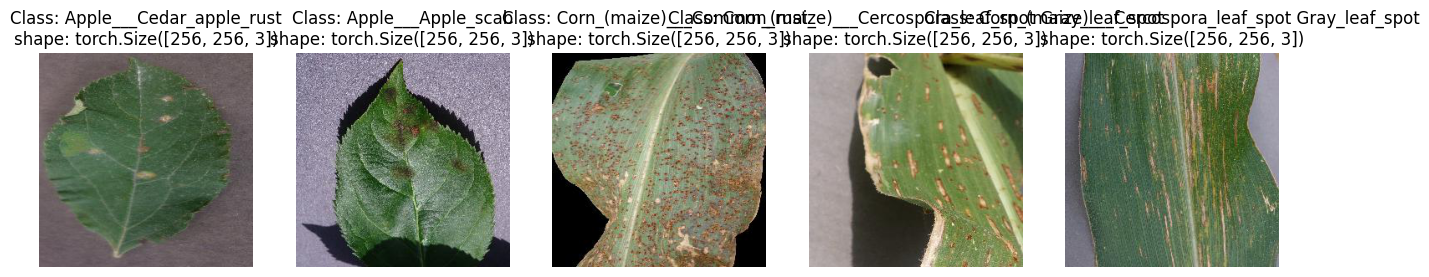

In [ ]:
display_random_images(train_dataset,
                      n=5,
                      classes=classes,
                      seed=42)


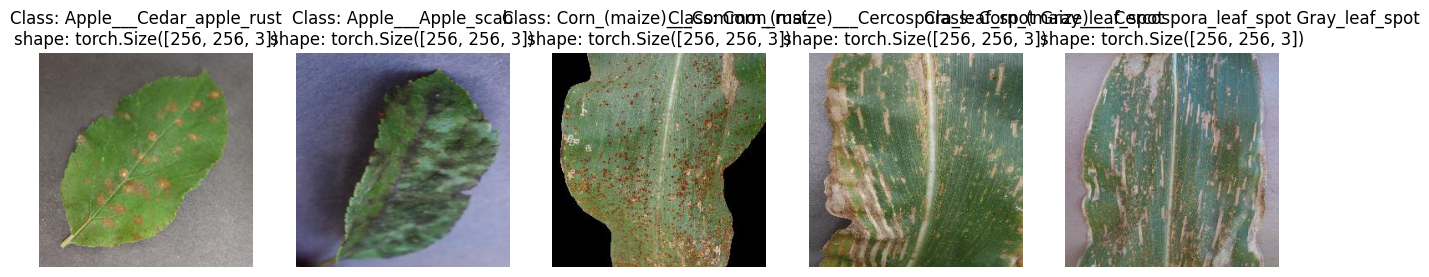

In [ ]:
display_random_images(test_dataset,
                      n=5,
                      classes=classes,
                      seed=42)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd84ae33a90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd84ae33820>)

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
             input_shape: int,
             hidden_units: int,
             output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2,)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*61*61,
                  out_features=output_shape)
    )

  def forward(self, x):
    x=self.conv_block_1(x)
    print(x.shape)
    x=self.conv_block_2(x)
    print(x.shape)
    x=self.classifier(x)
    print(x.shape)
    return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37210, out_features=14, bias=True)
  )
)

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0, input_size=(1,3,256,256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch.Size([1, 10, 126, 126])
torch.Size([1, 10, 61, 61])
torch.Size([1, 14])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 14]                   --
├─Sequential: 1-1                        [1, 10, 126, 126]         --
│    └─Conv2d: 2-1                       [1, 10, 254, 254]         280
│    └─ReLU: 2-2                         [1, 10, 254, 254]         --
│    └─Conv2d: 2-3                       [1, 10, 252, 252]         910
│    └─ReLU: 2-4                         [1, 10, 252, 252]         --
│    └─MaxPool2d: 2-5                    [1, 10, 126, 126]         --
├─Sequential: 1-2                        [1, 10, 61, 61]           --
│    └─Conv2d: 2-6                       [1, 10, 124, 124]         910
│    └─ReLU: 2-7                         [1, 10, 124, 124]         --
│    └─Conv2d: 2-8                       [1, 10, 122, 122]         910
│    └─ReLU: 2-9                         [1, 10, 122, 122]         --
│    └─MaxPool2d: 2-10                   [1, 10, 61, 61]           --
├─Sequentia

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss, train_acc=0,0
  for batch, (X,y) in enumerate(dataloader):
    print(batch)
    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()


    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+= (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:

img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 256, 256])

torch.Size([1, 10, 126, 126])
torch.Size([1, 10, 61, 61])
torch.Size([1, 14])
Output logits:
tensor([[ 0.0175,  0.0367,  0.0556,  0.0257, -0.0203, -0.0156,  0.0346,  0.0267,
         -0.0510, -0.0184,  0.1074, -0.0283, -0.0632,  0.0946]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.0716, 0.0729, 0.0743, 0.0722, 0.0689, 0.0692, 0.0728, 0.0722, 0.0668,
         0.0690, 0.0783, 0.0684, 0.0660, 0.0773]], device='cuda:0')

Output prediction label:
tensor([10], device='cuda:0')

Actual label:
7


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():

    for batch, (X,y) in enumerate(dataloader):
      print(batch)

      X,y = X.to(device), y.to(device)

      test_pred_logits = model(X)
      loss=loss_fn(test_pred_logits,y)
      test_loss+= loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss/ len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module= nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[],
             "current_lr":[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch:{epoch} | Train loss:{train_loss:4f} | Train acc:{train_acc:4f} | Test loss: {test_loss:.4f} | Test acc:{test_acc:.4f} | Learning rate:{current_lr}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["current_lr"].append(current_lr)

  return results

In [ ]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

TypeError: ignored

In [ ]:
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
model_0_df = pd.DataFrame(model_0_results)
model_0_df

In [ ]:
def plot_loss_curves(results:Dict[str, List[float]]):

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy =results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
train_transforms_augmented = transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.CenterCrop((256,256)),
                                                      transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.CenterCrop((256,256)),
                                                      transforms.ToTensor()
])

In [ ]:
train_dataset_augmented  = CustomDataset(train_files, labels[train_idx], transform=train_transforms_augmented)
test_dataset_simple = CustomDataset(test_files, labels[test_idx], transform=test_transform_simple)

In [ ]:
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_dataset_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_dataset_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f83ed7dbee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f83ed7da050>)

In [ ]:

torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_dataset_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37210, out_features=14, bias=True)
  )
)

In [ ]:

img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 256, 256])

torch.Size([1, 10, 126, 126])
torch.Size([1, 10, 61, 61])
torch.Size([1, 14])
Output logits:
tensor([[ 0.0168,  0.0350,  0.0550,  0.0256, -0.0180, -0.0168,  0.0313,  0.0279,
         -0.0452, -0.0181,  0.1074, -0.0271, -0.0618,  0.0930]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.0715, 0.0728, 0.0743, 0.0721, 0.0691, 0.0691, 0.0725, 0.0723, 0.0672,
         0.0691, 0.0783, 0.0684, 0.0661, 0.0772]], device='cuda:0')

Output prediction label:
tensor([10], device='cuda:0')

Actual label:
8


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[8,16], gamma=0.1)

from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

  0%|          | 0/20 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
128
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
129
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
128
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
129
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
130
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
131
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
130
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
131
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
132
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
133
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
134
torch.Size([32, 10, 126, 126])
torch.Size([32, 10, 61, 61])
torch.Size([32, 14])
132
torch.Size

In [ ]:
print(f"Total training time: {end_time-start_time:.3f} seconds")

Total training time: 3117.722 seconds


In [ ]:
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc,current_lr
0,1.861818,0.388542,1.129393,0.626645,0.00100
1,0.800283,0.713958,0.885001,0.695913,0.00100
2,0.603589,0.790903,0.714891,0.739689,0.00100
3,0.496632,0.824722,0.639492,0.779415,0.00100
4,0.436395,0.842986,0.631008,0.783907,0.00100
5,0.365487,0.865347,0.657288,0.776506,0.00100
6,0.299677,0.893750,0.584604,0.803201,0.00100
7,0.249264,0.914097,0.577831,0.798267,0.00010
8,0.138224,0.958889,0.481106,0.829517,0.00010
9,0.113257,0.969097,0.502148,0.829960,0.00010


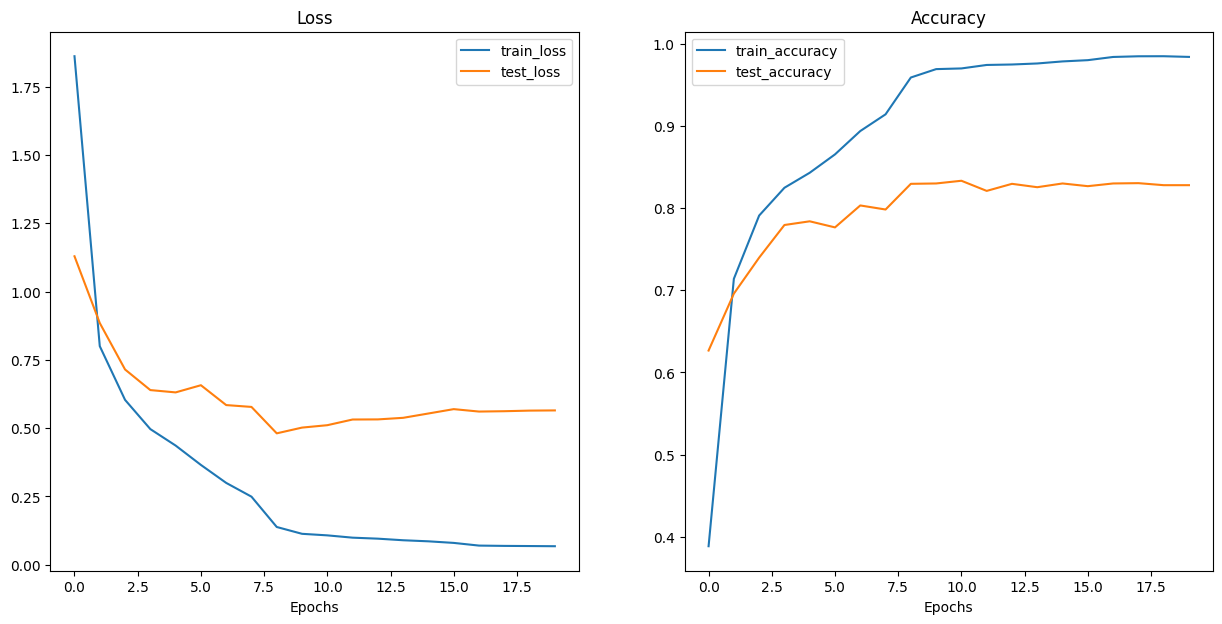

In [ ]:
plot_loss_curves(model_1_results)

##Predictions

In [ ]:
from shutil import copyfile

Prediction_image_path ='/content/drive/MyDrive/Datasets/prediction images/apple black rot.JPG'
desired_image_path='/content/Dataset/'

copyfile(Prediction_image_path, desired_image_path + 'apple black rot.JPG')

'/content/Dataset/apple black rot.JPG'

In [ ]:
custom_image_path='/content/Dataset/apple black rot.JPG'
custom_image=Image.open(custom_image_path)
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image/255

custom_image_transform = transforms.Compose([

    transforms.Resize((256,256)),
])
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4431, 0.4745, 0.5098,  ..., 0.6510, 0.5294, 0.5490],
         [0.3765, 0.4235, 0.4902,  ..., 0.5922, 0.5490, 0.5804],
         [0.4784, 0.4588, 0.5333,  ..., 0.4078, 0.6314, 0.5961],
         ...,
         [0.5059, 0.5216, 0.5490,  ..., 0.6549, 0.6627, 0.6863],
         [0.5490, 0.5647, 0.5804,  ..., 0.6392, 0.6431, 0.6588],
         [0.6235, 0.6314, 0.6275,  ..., 0.6196, 0.6235, 0.6392]],

        [[0.3725, 0.4039, 0.4392,  ..., 0.5961, 0.4745, 0.4941],
         [0.3059, 0.3529, 0.4196,  ..., 0.5373, 0.4941, 0.5255],
         [0.4078, 0.3882, 0.4627,  ..., 0.3529, 0.5765, 0.5412],
         ...,
         [0.4431, 0.4588, 0.4863,  ..., 0.6000, 0.6078, 0.6314],
         [0.4863, 0.5020, 0.5176,  ..., 0.5843, 0.5882, 0.6039],
         [0.5608, 0.5686, 0.5647,  ..., 0.5647, 0.5686, 0.5843]],

        [[0.4667, 0.4980, 0.5333,  ..., 0.6863, 0.5647, 0.5843],
         [0.4000, 0.4471, 0.5137,  ..., 0.6275, 0.5843, 0.6157],
         [0.5020, 0.4824, 0.5569,  ..

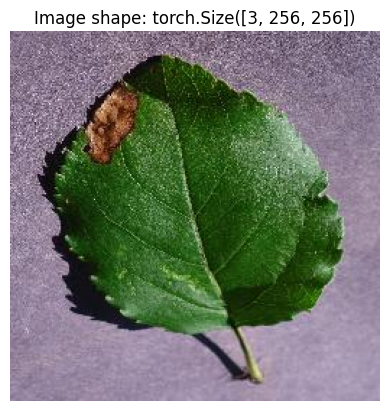

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image/255

    target_image = transform(target_image)

    model.to(device)
    model.eval()
    with torch.inference_mode():

        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.imshow(target_image.squeeze().permute(1, 2, 0))

    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

NameError: ignored

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=dir_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=dir_names,
                    transform=custom_image_transform,
                    device=device)

NameError: ignored

In [ ]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "Harvesttech_model_1.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: Models/Harvesttech_model_1.pth


In [ ]:
import torch
import torchvision.models as models

model =models.vgg16(pretrained=True)


# Load the weights from the .pth file
model.load_state_dict(torch.load('/content/Harvesttech_model_1.pth', map_location=torch.device('cpu')))
model.eval()

RuntimeError: ignored

In [ ]:
model.load_state_dict(torch.load('/content/Harvesttech_model_1.pth'))

RuntimeError: ignored

In [ ]:


# Define the path to the saved model on your local machine
MODEL_PATH = "/content/Harvesttech_model_1.pth"

# Create the model architecture
model = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(classes)).to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load(MODEL_PATH))

# Set the model to evaluation mode
model.eval()


NameError: ignored

In [ ]:
from google.colab import files

files.download('/content/Models/Harvesttech_model_1.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>